In [1]:
import sys
sys.path.append('../')
sys.path.append('../../')
from fig1_calibration import create_sim as cs
import pandas as pd

bounds = cs.define_pars(which='bounds',use_safegraph=True)
bounds['tn'][0] = 5.0
keys = list(bounds.keys())


# get maximin sample *not* including new designs?
def load_data(fp):
    return pd.read_csv(fp)[keys].drop_duplicates(keep='first')
designs = pd.concat(
    [
    load_data('../2024-07-03-sims_combined-tn-5.csv').assign(wave=0),
    load_data('../data/sims_combined-wave001.csv').assign(wave=1),
    load_data('../data/sims_combined-wave002.csv').assign(wave=2),
    load_data('../data/sims_combined-wave003.csv').assign(wave=3),
    load_data('../data/sims_combined-wave004.csv').assign(wave=4)
    ]
)


Covasim 2.1.2 (2021-03-31) — © 2021 by IDM


In [31]:
from sample_NI import sample_NI_maximin
from scipy.stats import qmc
validation = []
waves = [0,1,2,3,4]
sampler = qmc.LatinHypercube(d=4,seed=1)
sample = sampler.random(100_000)
wave0_LHS = pd.DataFrame(qmc.scale(sample,
                        l_bounds=[bounds[k][0] for k in keys],
                        u_bounds=[bounds[k][1] for k in keys]),columns=keys)
for wave in waves:
    # previous wave
    if wave==0:
        NI = wave0_LHS
    else:
        NI = pd.read_csv(f'../hm_waves/NI_pars_wave{wave-1:03d}.csv')
    designs_eligible = designs.query('wave>=@wave')
    eligible = pd.concat([NI[keys],designs_eligible[keys]]).drop_duplicates(subset=keys,keep=False)
    valid = sample_NI_maximin(df=eligible,n=10,seed=wave)
    valid = pd.DataFrame(valid,columns=keys).assign(wave=wave)
    validation.append(valid)
validation = pd.concat(validation)


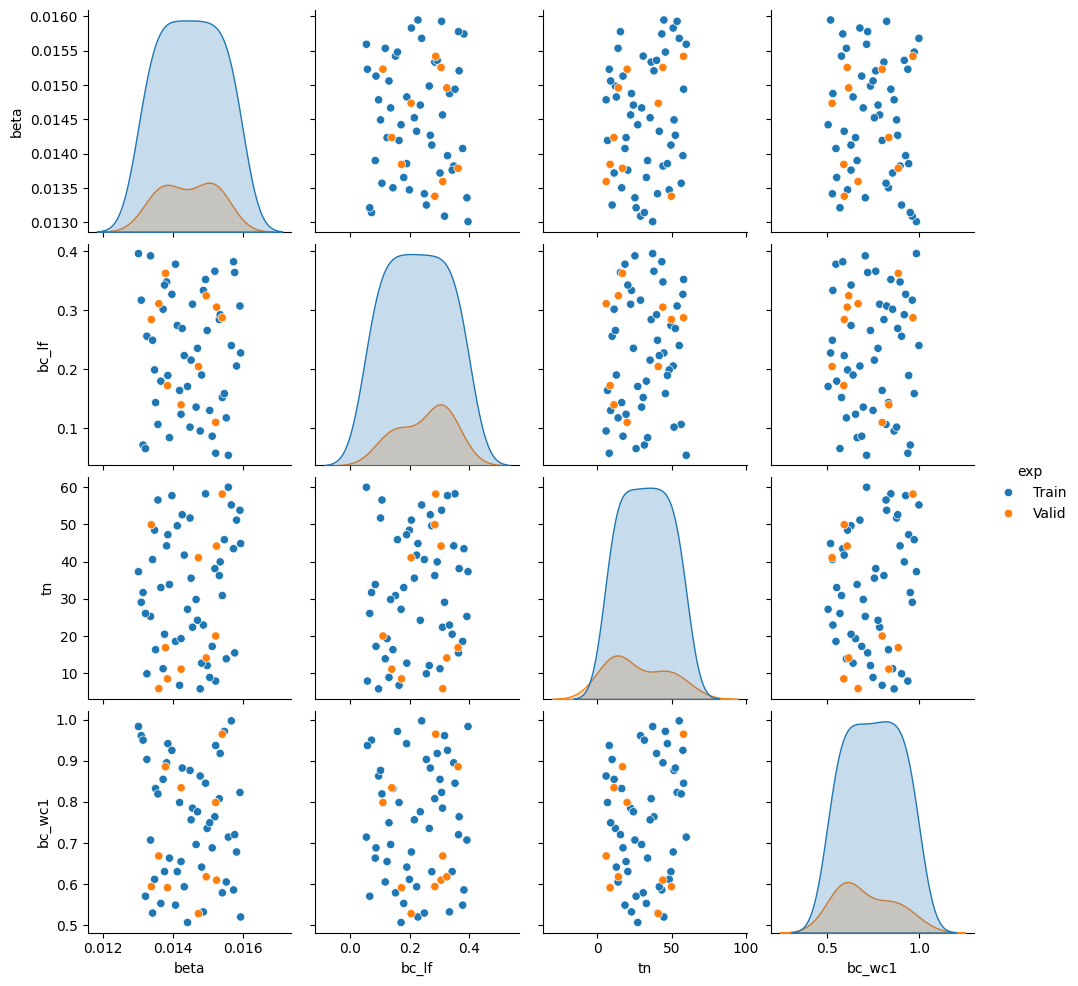

In [32]:
import seaborn as sns

def compare_designs_to_valid(wave=0):
    data = pd.concat([
        designs.query('wave==@wave').assign(exp='Train'),
        validation.query('wave==@wave').assign(exp='Valid')]
    )
    sns.pairplot(data[keys + ['exp']],hue='exp',
                 diag_kws=dict(common_norm=True))
compare_designs_to_valid(0)

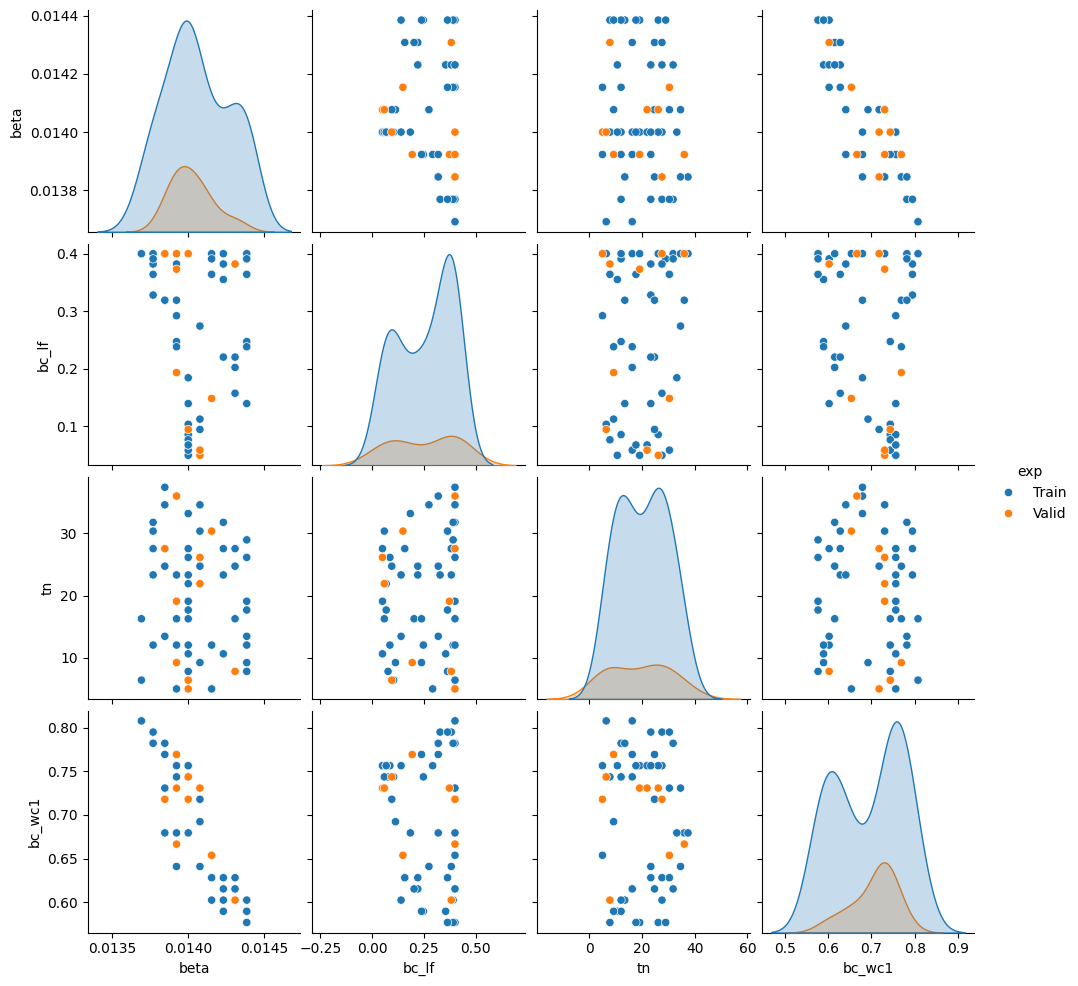

In [33]:
compare_designs_to_valid(4)

In [38]:
# rep
import numpy as np
validation_long = pd.DataFrame(np.repeat(validation.values,10,axis=0),columns=keys + ['wave'])
offset = 5351
validation_long['wave'] = validation_long['wave'].astype(int)
validation_long['rand_seed'] = np.arange(0,len(validation_long))
validation_long['rand_seed'] +=offset
validation_long.to_csv('../data/validation_pars.csv',index=False)